In [2]:
#Installations
import os

# Install pyspark & spark-nlp
! pip install spark-nlp==4.2.4 pyspark==3.2.1

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install geopy
!pip install geopy

# Install geopandas
!pip install --upgrade geopandas
!pip install geoplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk version "1.8.0_352"
OpenJDK Runtime Environment (build 1.8.0_352-8u352-ga-1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.352-b08, mixed mode)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Imports

import pyspark.sql.functions as F

import sparknlp

from sparknlp.annotator import Tokenizer
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Normalizer
from sparknlp.annotator import LemmatizerModel

import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sparknlp.annotator import StopWordsCleaner
from sparknlp.annotator import NGramGenerator
from sparknlp.annotator import PerceptronModel
from sparknlp.base import Finisher
from pyspark.ml import Pipeline
from pyspark.sql import types as T

import geopy
from geopy.geocoders import Nominatim

import geopandas as gpd
import geoplot

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
# Get data from drive & unzip
!unzip /content/gdrive/Shareddrives/ukraine-russia/ukraine-russia.zip

Archive:  /content/gdrive/Shareddrives/ukraine-russia/ukraine-russia.zip
   creating: ukraine-russia/
  inflating: ukraine-russia/08.csv   
  inflating: __MACOSX/ukraine-russia/._08.csv  
  inflating: ukraine-russia/09.csv   
  inflating: __MACOSX/ukraine-russia/._09.csv  
  inflating: ukraine-russia/02.csv   
  inflating: __MACOSX/ukraine-russia/._02.csv  
  inflating: ukraine-russia/03.csv   
  inflating: __MACOSX/ukraine-russia/._03.csv  
  inflating: ukraine-russia/04.csv   
  inflating: __MACOSX/ukraine-russia/._04.csv  
  inflating: ukraine-russia/10.csv   
  inflating: __MACOSX/ukraine-russia/._10.csv  
  inflating: ukraine-russia/05.csv   
  inflating: __MACOSX/ukraine-russia/._05.csv  
  inflating: ukraine-russia/07.csv   
  inflating: __MACOSX/ukraine-russia/._07.csv  
  inflating: ukraine-russia/06.csv   
  inflating: __MACOSX/ukraine-russia/._06.csv  


In [5]:
# Start spark
spark = sparknlp.start()

In [7]:
# read all data from all months

df = (spark.read.format("csv")
      .option("header", "true")
      .load("./ukraine-russia"))

df.count()

6588610

In [8]:
# Pro Ukraine
pro_ukraine_hashtags = ['standwithukraine', 'stoprussianaggression', 'putinisawarcriminal', 'saveukraine', 'freenavalny', 'fckputin', 'stopputin', 'slavaukraini', 'stoprussia', 'supportukraine', 'prayforukraine', 'standingwithukraine', 'gohomerussia', 'stopputinnow', 'fuckputin', 'natoinukrainenow', 'stopwar', 'stopthewar']

df2 = df.where(
    df['hashtags'].rlike("|".join(["(" + pat + ")" for pat in pro_ukraine_hashtags]))
)

df3 = df2.select('location', 'text').filter(F.col('location').isNotNull())
df3.show()
df3.count()

+---------------+------------------------------+
|       location|                          text|
+---------------+------------------------------+
|        Ucraina|          #StopPutinWar #St...|
|    Aracaju, SE|          """Cada vez mais ...|
|     New Jersey|          My first NFT is a...|
|        Торонто|          #stopthewar #Clos...|
|Ankara, Türkiye|          https://t.co/Cb7N...|
| Washington, DC|          It is pretty simp...|
|        Uruguay|          The entire city o...|
|  United States|          💯 #standwithukra...|
|             NJ|          @PeopleAreTrashy ...|
|            Usa|          Video footage of ...|
|    Chicago, IL|          Війна. День 13 ht...|
|         Canada|          #standwithukraine...|
|   Tokyo, Japan|みなさん気づいてた？Tim Coo...|
|        Belgium|          Brrr to read, à l...|
| washington, dc|          via @NYTimes #hum...|
|Česká republika|          year 68 - singer ...|
|  Rochester, NY|          Rockin for Ukrain...|
|    Raeford, NC|          A so

2172

In [9]:
# Pro Russia
pro_russia_hashtags = ['istandwithputin', 'istandwithrussia', 'standwithrussia', 'standwithputin', 'stopnato', 'westpropaganda', 'surrenderukraine']

df4 = df.where(
    df['hashtags'].rlike("|".join(["(" + pat + ")" for pat in pro_russia_hashtags]))
)

df5 = df4.select('location', 'text').filter(F.col('location').isNotNull())
df5.show()

+--------------------+--------------------+
|            location|                text|
+--------------------+--------------------+
|     Sagittarius A* |Why didn't @McDon...|
|           Australia|Why do you think ...|
|British Columbia,...|#russia #istandwi...|
|Planet Earth. Wor...|https://t.co/DxtO...|
|       United States|https://t.co/Mo8x...|
|           Miami, FL|@Schwarzenegger @...|
|       United States|https://t.co/oExM...|
|  cis white man cave|#RussiaUkraineCon...|
|    Toronto, Ontario|@54Battalion @Thu...|
|    Blackfoot, Idaho|History book titl...|
|    Palm Springs, CA|For those of you ...|
|Strawberry Shortc...|Ukraine, Has Fasc...|
|           Australia|Did NATO Provoke ...|
|Sankt Petersburg,...|I support Russia ...|
|       United States|https://t.co/De1w...|
|     London, England|So dirty #India a...|
|      Lagos, Nigeria|The US and it all...|
|           Luxumberg|Alle die meinen d...|
|       Planet Earth |"Watch @Zelenskyy...|
|ÜT: -6.163141,106...|#Russians 

In [10]:
# Preprocess Text
def preprocess_data(indf):
  indf = indf.filter(indf.text.isNotNull())
  #tweet_col = ('location','text')
  review_text = indf.select("location","text").filter(F.col("location").isNotNull())
  clean = review_text.withColumn('text', F.regexp_replace('text', r"http\S+", ''))
  clean = clean.withColumn('text', F.regexp_replace('text', r"\w+followback\w+", ''))
  clean = clean.withColumn('text', F.regexp_replace('text', '#', ''))
  clean = clean.withColumn('text', F.regexp_replace('text', 'RT', ''))
  clean_text = clean.withColumn('text', F.regexp_replace('text', ':', ''))
  return clean_text

df_ukraine = preprocess_data(df3)
df_russia = preprocess_data(df5)

In [11]:
#define geoLocation
geolocator = Nominatim(timeout=10, user_agent = "my-application")

In [12]:
# Add Latitude & Longitude columns
def getLatitude(locationName):
  location = geolocator.geocode(locationName)
  if location is None:
    return None
  else:
      return location.latitude

def getLongitude(locationName):
  location = geolocator.geocode(locationName)
  if location is None:
    return None
  else:
      return location.longitude

udfLatitude = F.udf(getLatitude, T.StringType())
udfLongitude = F.udf(getLongitude, T.StringType())

df_russia1 = df_russia.withColumn("latitude", udfLatitude("location")).withColumn("longitude", udfLongitude("location"))
df_russia1.show(10)

+--------------------+--------------------+-----------+-----------+
|            location|                text|   latitude|  longitude|
+--------------------+--------------------+-----------+-----------+
|     Sagittarius A* |Why didn't @McDon...| 14.6049281|121.1665811|
|           Australia|Why do you think ...|-24.7761086|    134.755|
|British Columbia,...|russia istandwith...|  55.001251|-125.002441|
|Planet Earth. Wor...| -19 Ukraine Russ...|       null|       null|
|       United States| dragonball drago...| 39.7837304|-100.445882|
|           Miami, FL|@Schwarzenegger @...| 25.7741728|  -80.19362|
|       United States| dragonball drago...| 39.7837304|-100.445882|
|  cis white man cave|RussiaUkraineConf...|       null|       null|
|    Toronto, Ontario|@54Battalion @Thu...| 43.6534817|-79.3839347|
|    Blackfoot, Idaho|History book titl...|  43.190039|-112.348357|
+--------------------+--------------------+-----------+-----------+
only showing top 10 rows



In [26]:
# UKRAINE
# Add Latitude & Longitude columns
def getLatitude(locationName):
  location = geolocator.geocode(locationName)
  if location is None:
    return None
  else:
      return location.latitude

def getLongitude(locationName):
  location = geolocator.geocode(locationName)
  if location is None:
    return None
  else:
      return location.longitude

udfLatitude = F.udf(getLatitude, T.StringType())
udfLongitude = F.udf(getLongitude, T.StringType())

df_ukraine1 = df_ukraine.withColumn("latitude", udfLatitude("location")).withColumn("longitude", udfLongitude("location"))
df_ukraine1.show(10)

+---------------+--------------------+-----------+-----------+
|       location|                text|   latitude|  longitude|
+---------------+--------------------+-----------+-----------+
|        Ucraina|StopPutinWar Stop...| 49.4871968| 31.2718321|
|    Aracaju, SE|"""Cada vez mais ...|-10.9162061|-37.0774655|
|     New Jersey|My first NFT is a...| 40.0757384|-74.4041622|
|        Торонто|stopthewar CloseT...| 43.6534817|-79.3839347|
|Ankara, Türkiye|          stoprussia| 39.9207886| 32.8540482|
| Washington, DC|It is pretty simp...| 38.8950368|-77.0365427|
|        Uruguay|The entire city o...|-32.8755548|-56.0201525|
|  United States|💯 standwithukrai...| 39.7837304|-100.445882|
|             NJ|@PeopleAreTrashy ...| 40.0757384|-74.4041622|
|            Usa|Video footage of ...| 39.7837304|-100.445882|
+---------------+--------------------+-----------+-----------+
only showing top 10 rows



In [ ]:
# Filter & Save to csv
df_russia2 = df_russia1.filter((F.col("latitude").isNotNull()) | (F.col("longitude").isNotNull()))
df_russia2.write.options(header='True', delimiter=',').csv("./geoLocationRussia.csv")

In [ ]:
# UKRAINE
# Filter & Save to csv
df_ukraine2 = df_ukraine1.filter((F.col("latitude").isNotNull()) | (F.col("longitude").isNotNull()))
df_ukraine2.write.options(header='True', delimiter=',').csv("./geoLocationUkraine.csv")

In [14]:
# Read from exported csv
df_russia3 = spark.read.csv("./geoLocationRussia.csv", header=True,  inferSchema=True)
df_russia3.show()
df_russia3.count()

+--------------------+--------------------+------------------+-------------------+
|            location|                text|          latitude|          longitude|
+--------------------+--------------------+------------------+-------------------+
|      Sagittarius A*|Why didn't @McDon...|        14.6049281|        121.1665811|
|           Australia|Why do you think ...|       -24.7761086|            134.755|
|British Columbia,...|russia istandwith...|         55.001251|        -125.002441|
|       United States|dragonball dragon...|        39.7837304|        -100.445882|
|           Miami, FL|@Schwarzenegger @...|        25.7741728|          -80.19362|
|       United States|dragonball dragon...|        39.7837304|        -100.445882|
|    Toronto, Ontario|@54Battalion @Thu...|        43.6534817|        -79.3839347|
|    Blackfoot, Idaho|History book titl...|         43.190039|        -112.348357|
|    Palm Springs, CA|For those of you ...|33.772179449999996|-116.49529769683983|
|   

45

In [ ]:
# UKRAINE
# Read from exported csv
df_ukraine3 = spark.read.csv("./geoLocationUkraine.csv", header=True,  inferSchema=True)
df_ukraine3.show()
df_ukraine3.count()

In [15]:
# PySpark DF to pandas DF
pandas_df = df_russia3.toPandas()
pandas_df

,location,text,latitude,longitude
0,Sagittarius A*,Why didn't @McDonalds shutdown in the United S...,14.604928,121.166581
1,Australia,Why do you think Putin keeps saying Ukraine go...,-24.776109,134.755000
2,"British Columbia, Canada",russia istandwithputin ukraine istandwithrussi...,55.001251,-125.002441
3,United States,dragonball dragonballz dragonballsuper vegeta ...,39.783730,-100.445882
4,"Miami, FL",@Schwarzenegger @Ukraine @MFA_Ukraine @Canada ...,25.774173,-80.193620
5,United States,dragonball dragonballz dragonballsuper vegeta ...,39.783730,-100.445882
6,"Toronto, Ontario",@54Battalion @ThuliMadonsela3 istandwithrussia...,43.653482,-79.383935
7,"Blackfoot, Idaho",History book title “Russia’s Shame - Putin’s D...,43.190039,-112.348357
8,"Palm Springs, CA",For those of you that istandwithputin . You h...,33.772179,-116.495298
9,Australia,Did NATO Provoke Russia Into The Ukraine Confl...,-24.776109,134.755000


In [ ]:
# UKRAINE
# PySpark DF to pandas DF
pandas_df_ukraine = df_ukraine3.toPandas()

gdf_ukraine = gpd.GeoDataFrame(pandas_df_ukraine, geometry=gpd.points_from_xy(pandas_df_ukraine.longitude, pandas_df_ukraine.latitude))
gdf_ukraine

In [16]:
# Add column with Points as Geometry from lat & long
gdf = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df.longitude, pandas_df.latitude))
print(gdf.head())

                   location  \
0            Sagittarius A*   
1                 Australia   
2  British Columbia, Canada   
3             United States   
4                 Miami, FL   

                                                text   latitude   longitude  \
0  Why didn't @McDonalds shutdown in the United S...  14.604928  121.166581   
1  Why do you think Putin keeps saying Ukraine go... -24.776109  134.755000   
2  russia istandwithputin ukraine istandwithrussi...  55.001251 -125.002441   
3  dragonball dragonballz dragonballsuper vegeta ...  39.783730 -100.445882   
4  @Schwarzenegger @Ukraine @MFA_Ukraine @Canada ...  25.774173  -80.193620   

                      geometry  
0   POINT (121.16658 14.60493)  
1  POINT (134.75500 -24.77611)  
2  POINT (-125.00244 55.00125)  
3  POINT (-100.44588 39.78373)  
4   POINT (-80.19362 25.77417)  


In [17]:
gdf

,location,text,latitude,longitude,geometry
0,Sagittarius A*,Why didn't @McDonalds shutdown in the United S...,14.604928,121.166581,POINT (121.16658 14.60493)
1,Australia,Why do you think Putin keeps saying Ukraine go...,-24.776109,134.755000,POINT (134.75500 -24.77611)
2,"British Columbia, Canada",russia istandwithputin ukraine istandwithrussi...,55.001251,-125.002441,POINT (-125.00244 55.00125)
3,United States,dragonball dragonballz dragonballsuper vegeta ...,39.783730,-100.445882,POINT (-100.44588 39.78373)
4,"Miami, FL",@Schwarzenegger @Ukraine @MFA_Ukraine @Canada ...,25.774173,-80.193620,POINT (-80.19362 25.77417)
5,United States,dragonball dragonballz dragonballsuper vegeta ...,39.783730,-100.445882,POINT (-100.44588 39.78373)
6,"Toronto, Ontario",@54Battalion @ThuliMadonsela3 istandwithrussia...,43.653482,-79.383935,POINT (-79.38393 43.65348)
7,"Blackfoot, Idaho",History book title “Russia’s Shame - Putin’s D...,43.190039,-112.348357,POINT (-112.34836 43.19004)
8,"Palm Springs, CA",For those of you that istandwithputin . You h...,33.772179,-116.495298,POINT (-116.49530 33.77218)
9,Australia,Did NATO Provoke Russia Into The Ukraine Confl...,-24.776109,134.755000,POINT (134.75500 -24.77611)


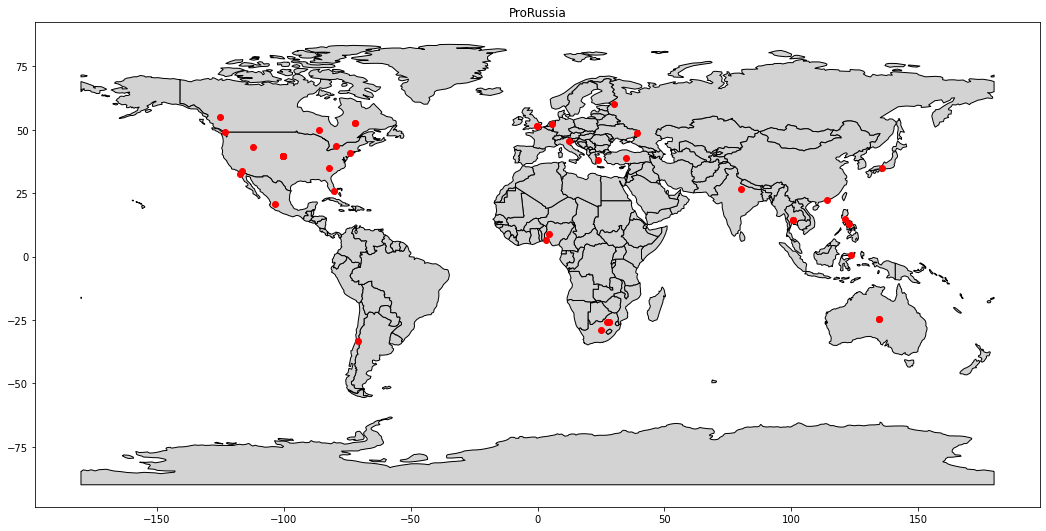

In [25]:
# Plot locations
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='lightgrey', edgecolor='black')
ax.set_title("ProRussia")
gdf.crs = 'epsg:3395'
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:
# UKRAINE
# Plot locations
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='lightgrey', edgecolor='black')
ax.set_title("ProUkraine")

gdf_ukraine.crs = 'epsg:3395'
gdf_ukraine.plot(ax=ax, color='blue')

plt.show()

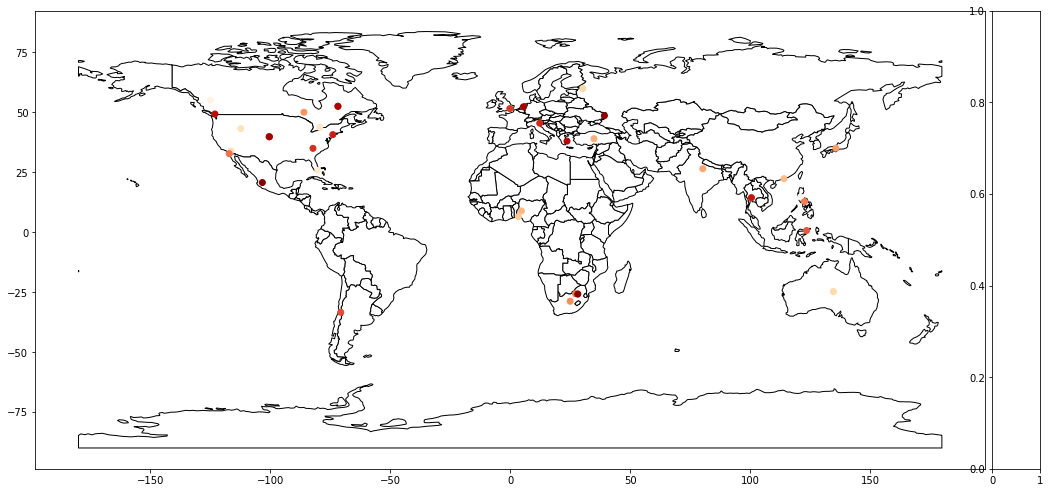

In [21]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [18, 10]

ax = world.plot(color='white', edgecolor='black')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

gdf.plot(ax=ax, legend=True, figsize=(18,18), cax=cax, cmap='OrRd')#, scheme='quantiles')